# EDA and Modelling 
### Real Estate - Housing

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import folium


from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [5]:
#https://www.kaggle.com/anthonypino/melbourne-housing-market?select=Melbourne_housing_FULL.csv
df = pd.read_csv('housing_data_full.csv')

df = df[~df['Price'].isnull()] # Removing all entries where the target value is null
df = df.drop(columns=['Address','Postcode'])
df = df.dropna()
df['Date'] = pd.to_datetime(df['Date'])
df.Price = df.Price.astype(int)
df = df.reset_index(drop=True)
display(df.columns)
pd.concat([df.nunique(),df.dtypes], axis=1)

Index(['Suburb', 'Rooms', 'Type', 'Price', 'Method', 'SellerG', 'Date',
       'Distance', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea',
       'YearBuilt', 'CouncilArea', 'Lattitude', 'Longtitude', 'Regionname',
       'Propertycount'],
      dtype='object')

0               1
Suburb          315          object
Rooms            10           int64
Type              3          object
Price          1846           int32
Method            5          object
SellerG         250          object
Date             77  datetime64[ns]
Distance        201         float64
Bedroom2         12         float64
Bathroom          9         float64
Car              11         float64
Landsize       1237         float64
BuildingArea    465         float64
YearBuilt       143         float64
CouncilArea      33          object
Lattitude      5661         float64
Longtitude     6070         float64
Regionname        8          object
Propertycount   312         float64

In [6]:
df['Regionname'].unique()

array(['Northern Metropolitan', 'Western Metropolitan',
       'Southern Metropolitan', 'Eastern Metropolitan',
       'South-Eastern Metropolitan', 'Northern Victoria',
       'Eastern Victoria', 'Western Victoria'], dtype=object)

In [7]:
df.head()

Suburb  Rooms Type    Price Method SellerG       Date  Distance  \
0  Abbotsford      2    h  1035000      S  Biggin 2016-04-02       2.5   
1  Abbotsford      3    h  1465000     SP  Biggin 2017-04-03       2.5   
2  Abbotsford      4    h  1600000     VB  Nelson 2016-04-06       2.5   
3  Abbotsford      3    h  1876000      S  Nelson 2016-07-05       2.5   
4  Abbotsford      2    h  1636000      S  Nelson 2016-08-10       2.5   

   Bedroom2  Bathroom  Car  Landsize  BuildingArea  YearBuilt  \
0       2.0       1.0  0.0     156.0          79.0     1900.0   
1       3.0       2.0  0.0     134.0         150.0     1900.0   
2       3.0       1.0  2.0     120.0         142.0     2014.0   
3       4.0       2.0  0.0     245.0         210.0     1910.0   
4       2.0       1.0  2.0     256.0         107.0     1890.0   

          CouncilArea  Lattitude  Longtitude             Regionname  \
0  Yarra City Council   -37.8079    144.9934  Northern Metropolitan   
1  Yarra City Council   -37.8093    144.9944  Northern Metropolitan   
2  Yarra City Council   -37.8072    144.9941  Northern Metropolitan   
3  Yarra City Council   -37.8024    144.9993  Northern Metropolitan   
4  Yarra City Council   -37.8060    144.9954  Northern Metropolitan   

   Propertycount  
0         4019.0  
1         4019.0  
2         4019.0  
3         4019.0  
4         4019.0

Price            1.000000
BuildingArea     0.507278
Rooms            0.475074
Bathroom         0.463501
Bedroom2         0.460880
Longtitude       0.212174
Car              0.209464
Landsize         0.058375
Propertycount   -0.059720
Lattitude       -0.224255
Distance        -0.231212
YearBuilt       -0.313664
Name: Price, dtype: float64

<AxesSubplot:>

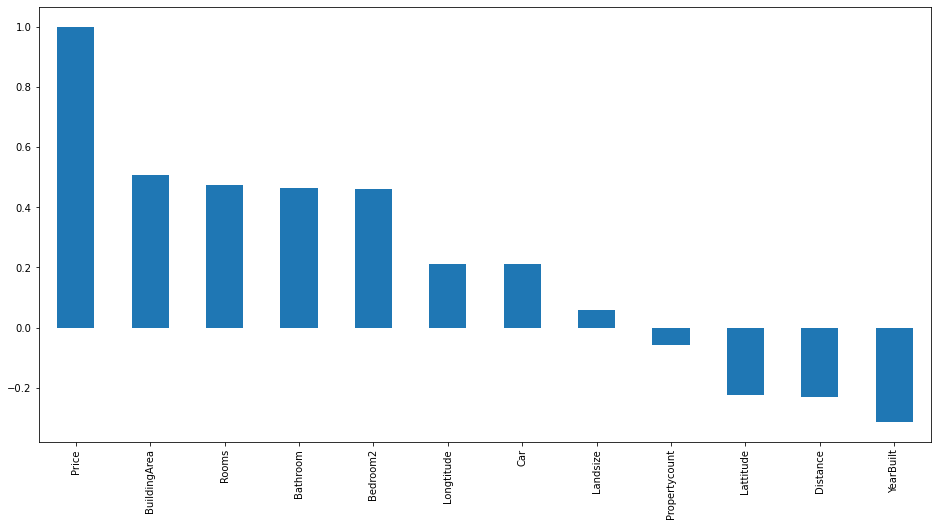

In [8]:
plt.figure(figsize=(16,8))
display(df.corr()['Price'].sort_values(ascending = False))
df.corr()['Price'].sort_values(ascending = False).plot(kind='bar')

# Exploring price distribution
## The below plots indicate that there is positive skewness in price distribution for houses with 2 rooms, which clearly indicates that many houses are sold less than the average market price and centrain houses have extreme prices

<AxesSubplot:ylabel='Frequency'>

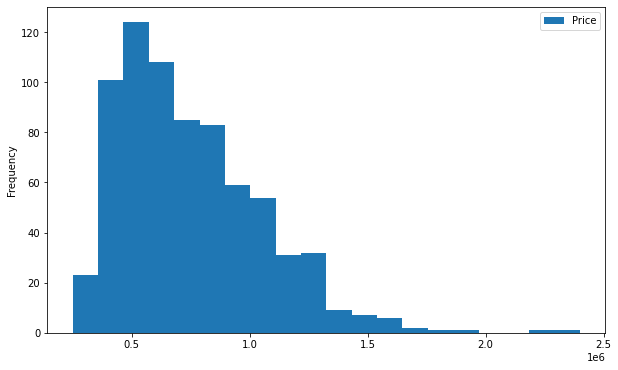

In [9]:
df[(df['Regionname']=='Northern Metropolitan')&(df['Rooms']==2)][['Price']].sort_values(by='Price',ascending = False).plot(kind='hist', bins=20, figsize=(10, 6))


## Extreme vs Normal price distribution of 2 room houses for Melborne

<AxesSubplot:ylabel='Frequency'>

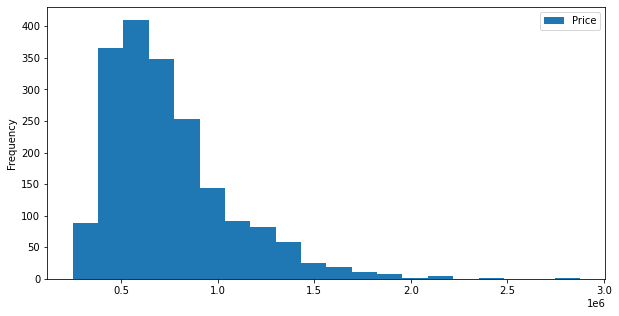

In [10]:
#df[(df['Regionname']=='Northern Metropolitan')&(df['Rooms']==2)][['Date','Price']].sort_values(by='Date',ascending = False).set_index('Date').plot(figsize=(20, 6))
two_rooms_df = df[(df['Rooms']==2)]
two_rooms_df[['Price']].sort_values(by='Price',ascending = False).plot(kind='hist', bins=20, figsize=(10, 5))

<AxesSubplot:>

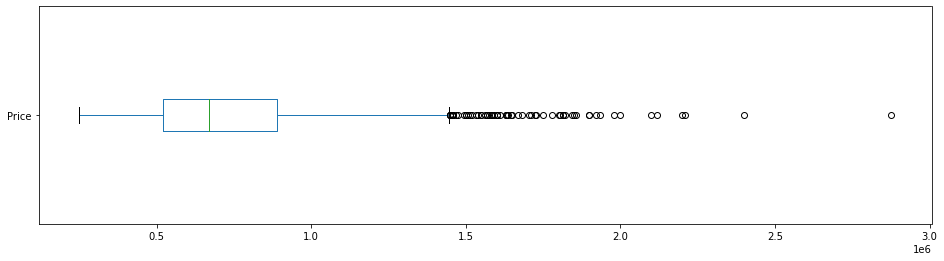

In [11]:
two_rooms_df[['Price']].sort_values(by='Price',ascending = False).plot(kind='box',vert=False, figsize=(16, 4))

In [12]:
display(two_rooms_df[['Price']].describe().T)
#Mean > Median -> Right Skew
desc = two_rooms_df[['Price']].describe().T
is_right_skewed = 'Yes' if (desc.loc['Price', 'mean'] > desc.loc['Price', '50%']) else 'No'
print(f'Is right skewed?: { is_right_skewed }')

count           mean            std       min       25%       50%  \
Price  1912.0  747038.203452  312862.042372  250000.0  520000.0  670000.0   

            75%        max  
Price  890000.0  2875000.0

Is right skewed?: Yes


In [13]:
Q3 = desc.loc['Price', '75%']
Q1 = desc.loc['Price', '25%']
IQR = Q3 - Q1
upper_threshold =  Q3 + (1.5 * IQR)
upper_threshold

extreme_prices= two_rooms_df[(two_rooms_df['Price']>upper_threshold)]
normal_prices= two_rooms_df[(two_rooms_df['Price']<upper_threshold)]
#df[(df['Price']>upper_threshold)&(df['Rooms']==2)]

## Map Lat/Lng of different houses from Melborne
- Red circles - extreme prices
- Green circles - normal prices 

## 3 Maps, Extreme vs Normal house prices

- Total 
- Regional Level 
- Suburb Level

In [14]:
m = folium.Map(location=[-37.8,145], zoom_start=11)

for lat,long in zip(normal_prices.Lattitude, normal_prices.Longtitude):
    folium.Circle(
    radius=10,
    location=[lat,long],
    popup="The Waterfront",
    color="green",
    fill=False,
).add_to(m)
    
for lat,long in zip(extreme_prices.Lattitude, extreme_prices.Longtitude):
    folium.Circle(
    radius=10,
    location=[lat,long],
    popup="The Waterfront",
    color="red",
    fill=False,
).add_to(m)
#    folium.Marker( location=[ coord[0], coord[1] ], fill_color='#43d9de', radius=8 ).add_to( m )
m

## Extreme vs Normal price distribution for 2 room houses in one of the Region in Melborne

In [15]:
normal_prices_in_a_region = normal_prices[(normal_prices['Regionname']=='Northern Metropolitan')]
extreme_prices_in_a_region = extreme_prices[(extreme_prices['Regionname']=='Northern Metropolitan')]

m = folium.Map(location=[-37.8,145], zoom_start=11)

for lat,long in zip(normal_prices_in_a_region.Lattitude, normal_prices_in_a_region.Longtitude):
    folium.Circle(
    radius=10,
    location=[lat,long],
    popup="The Waterfront",
    color="green",
    fill=False,
).add_to(m)
    
for lat,long in zip(extreme_prices_in_a_region.Lattitude, extreme_prices_in_a_region.Longtitude):
    folium.Circle(
    radius=10,
    location=[lat,long],
    popup="The Waterfront",
    color="red",
    fill=False,
).add_to(m)
#    folium.Marker( location=[ coord[0], coord[1] ], fill_color='#43d9de', radius=8 ).add_to( m )
m

## Extreme vs Normal price distribution for 2 room houses in one of the Suburb in Melborne

In [16]:
normal_prices_in_a_Suburb = normal_prices[(normal_prices['Suburb']=='Abbotsford')]
extreme_prices_in_a_Suburb = extreme_prices[(extreme_prices['Suburb']=='Abbotsford')]

m = folium.Map(location=[-37.8,145], zoom_start=14)

for lat,long in zip(normal_prices_in_a_Suburb.Lattitude, normal_prices_in_a_Suburb.Longtitude):
    folium.Circle(
    radius=10,
    location=[lat,long],
    popup="The Waterfront",
    color="green",
    fill=False,
).add_to(m)
    
for lat,long in zip(extreme_prices_in_a_Suburb.Lattitude, extreme_prices_in_a_Suburb.Longtitude):
    folium.Circle(
    radius=10,
    location=[lat,long],
    popup="The Waterfront",
    color="red",
    fill=False,
).add_to(m)
#    folium.Marker( location=[ coord[0], coord[1] ], fill_color='#43d9de', radius=8 ).add_to( m )
m

# Calculating new target label PriceReasoning using statistical methods

## PriceReasoning
- Extreme 1 - an indicator for risk factor/ banks can quickly check this criteria before they approve a loan amount.
- Normal 0

### Lable the dataset Extreme or Normal price based on statistical analysis of price distribution.
number of rooms is positively corelated with the price

In [17]:
df['PriceReasoning'] = 0 # 0 - Normal price; 1 - Extreme price
rooms_counts = df['Rooms'].unique()
for room_count in rooms_counts:
    rooms_df=df[(df['Rooms']==room_count)]
    desc = rooms_df[['Price']].describe().T
    Q3 = desc.loc['Price', '75%']
    Q1 = desc.loc['Price', '25%']
    IQR = Q3 - Q1
    upper_threshold =  Q3 + (1.5 * IQR)
    extreme_prices= rooms_df[(rooms_df['Price']>upper_threshold)]
    normal_prices= rooms_df[(rooms_df['Price']<upper_threshold)]
    df.loc[list(extreme_prices.index),['PriceReasoning']] = 1
    #df.loc[list(normal_prices.index),['PriceReasoning']] = 0
    
total_e_prices = df[['PriceReasoning']].sum() 

print(f'Total extreme priced houses : {total_e_prices.PriceReasoning}')

Total extreme priced houses : 291


PriceReasoning    1.000000
Price             0.471453
BuildingArea      0.123791
Bathroom          0.096285
Car               0.035364
Longtitude        0.035235
Landsize          0.008202
Bedroom2          0.004085
Propertycount    -0.003089
Rooms            -0.009698
Lattitude        -0.075807
Distance         -0.125653
YearBuilt        -0.153093
Name: PriceReasoning, dtype: float64

<AxesSubplot:>

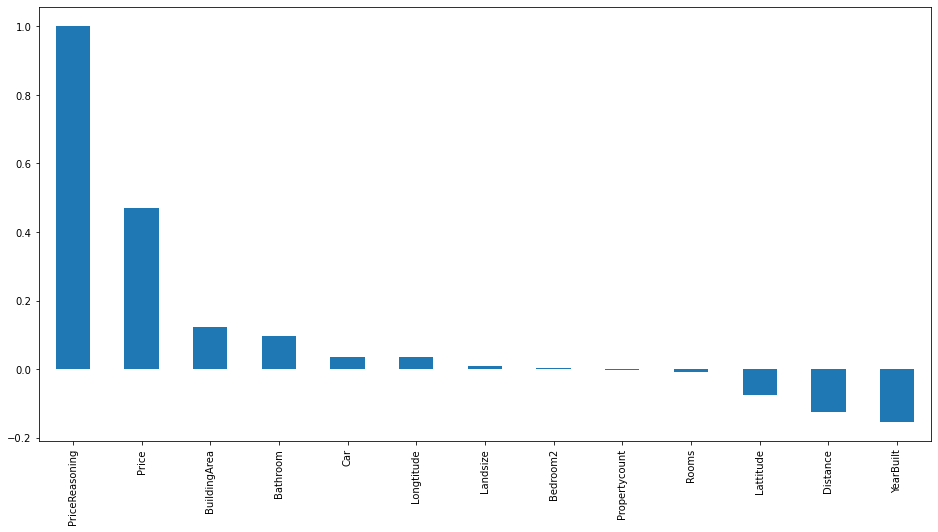

In [18]:
plt.figure(figsize=(16,8))
display(df.corr()['PriceReasoning'].sort_values(ascending = False))
df.corr()['PriceReasoning'].sort_values(ascending = False).plot(kind='bar')

In [19]:
info=pd.concat([df.nunique(),df.dtypes], axis=1)
info.sort_values(by=1)

0               1
Price           1846           int32
PriceReasoning     2           int64
Rooms             10           int64
Longtitude      6070         float64
Lattitude       5661         float64
YearBuilt        143         float64
BuildingArea     465         float64
Landsize        1237         float64
Car               11         float64
Bathroom           9         float64
Bedroom2          12         float64
Distance         201         float64
Date              77  datetime64[ns]
Propertycount    312         float64
SellerG          250          object
CouncilArea       33          object
Method             5          object
Type               3          object
Regionname         8          object
Suburb           315          object

In [20]:
df = df.drop(columns=['SellerG','Date','Suburb']) # High cardinality columns are removed as they will explode while creating one hot encoding
x = df.drop(columns=['PriceReasoning'])
ohe_df = pd.get_dummies(x)
ohe_df['PriceReasoning'] = df['PriceReasoning']

PriceReasoning                          1.000000
Price                                   0.471453
Regionname_Southern Metropolitan        0.191453
CouncilArea_Stonnington City Council    0.176749
BuildingArea                            0.123791
                                          ...   
Type_u                                 -0.059180
Lattitude                              -0.075807
Regionname_Western Metropolitan        -0.092045
Distance                               -0.125653
YearBuilt                              -0.153093
Name: PriceReasoning, Length: 62, dtype: float64

<AxesSubplot:>

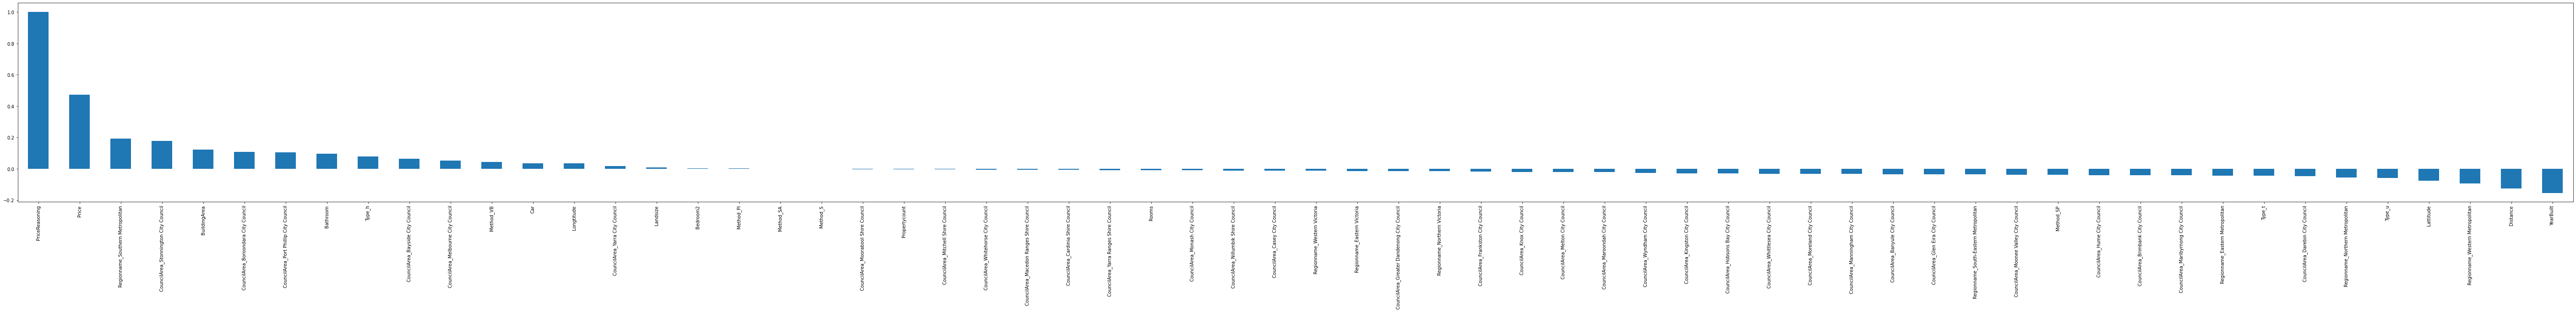

In [21]:
plt.figure(figsize=(100,8))
display(ohe_df.corr()['PriceReasoning'].sort_values(ascending = False))
ohe_df.corr()['PriceReasoning'].sort_values(ascending = False).plot(kind='bar')

In [22]:
X = ohe_df.drop(columns=['PriceReasoning'])
Y = ohe_df['PriceReasoning']

features = X.columns.values
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X))
X.columns = features
"""
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X))
"""
rand_under_sample = RandomUnderSampler(random_state=1)
X_u, Y_u = rand_under_sample.fit_resample(X,Y)
"""
tomekl = TomekLinks(n_jobs=3)
X_u, Y_u = tomekl.fit_resample(X, Y)
"""

X_train, X_test, y_train, y_test = train_test_split(X_u, Y_u, test_size=0.3, random_state=1)
#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

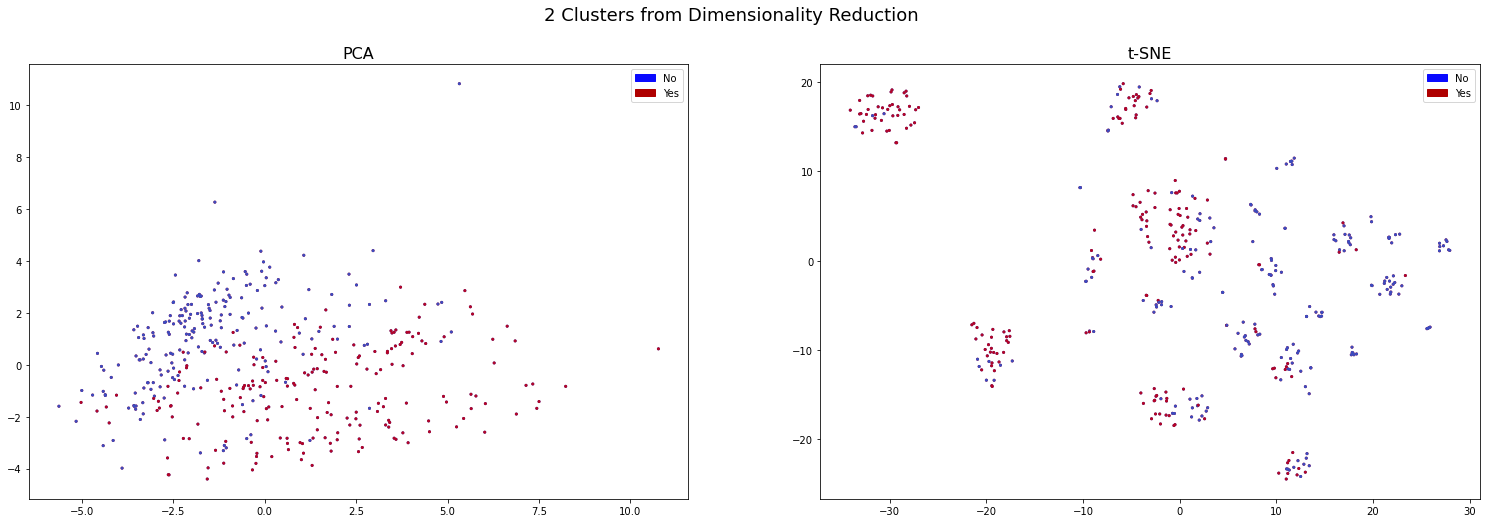

In [23]:
X_pca = PCA(n_components=2, random_state=1).fit_transform(X_train)
X_tsne = TSNE(n_components=2, random_state=1).fit_transform(X_train)

red_patch = mpatches.Patch(color='#AF0000', label='Yes')
blue_patch = mpatches.Patch(color='#0A0AFF', label='No')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(26,8))
fig.suptitle('2 Clusters from Dimensionality Reduction', fontsize=18)

ax1.set_title('PCA', fontsize=16)
ax1.scatter(X_pca[:,0], X_pca[:,1], s=4, c=(y_train == 0), cmap='coolwarm', linewidths=1)
ax1.scatter(X_pca[:,0], X_pca[:,1], s=4, c=(y_train == 1), cmap='coolwarm', linewidths=1)
ax1.legend(handles=[blue_patch, red_patch])

ax2.set_title('t-SNE', fontsize=16)
ax2.scatter(X_tsne[:,0], X_tsne[:,1], s=4, c=(y_train == 0), cmap='coolwarm', linewidths=1)
ax2.scatter(X_tsne[:,0], X_tsne[:,1], s=4, c=(y_train == 1), cmap='coolwarm', linewidths=1)
ax2.legend(handles=[blue_patch, red_patch])

0.96
AxesSubplot(0.125,0.125;0.775x0.755)


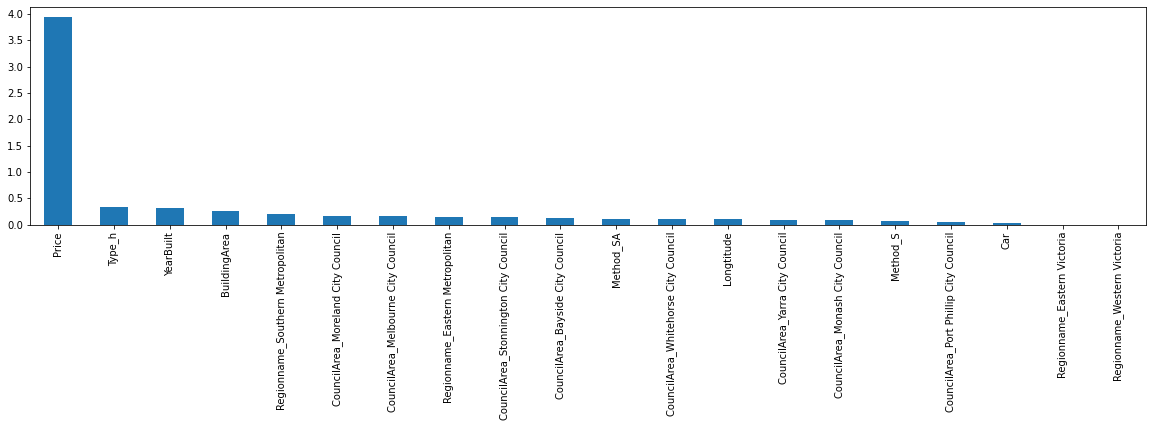

In [24]:
model = LogisticRegression()
result = model.fit(X_train, y_train)

prediction_test = model.predict(X_test)
print(accuracy_score(y_test, prediction_test))

weights = pd.Series(model.coef_[0], index=X.columns.values)
print(weights.sort_values(ascending = False)[:20].plot(kind='bar' ,figsize=(20,4)))

0.96
Accuracy: 0.96 
Precision: 0.97 
Recall: 0.96 
F score: 0.96


<AxesSubplot:>

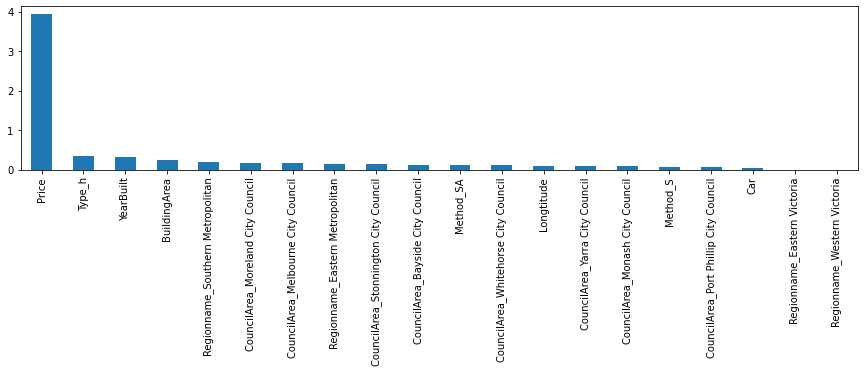

In [64]:
model = LogisticRegression()
result = model.fit(X_train, y_train)

prediction_test = model.predict(X_test)
print(accuracy_score(y_test, prediction_test))

coefficients = pd.Series(model.coef_[0], index=X.columns.values)

precision = round(precision_score(y_test,prediction_test),2)
recall = round(recall_score(y_test,prediction_test),2)
fscore = round(f1_score(y_test,prediction_test),2)
accuracy = round(accuracy_score(y_test,prediction_test),2)

print(f'Accuracy: {accuracy} \nPrecision: {precision} \nRecall: {recall} \nF score: {fscore}')
coefficients.sort_values(ascending = False)[:20].plot(kind='bar',figsize=(15,3))

In [26]:
from sklearn.svm import SVC
model.svm = SVC(kernel='linear') 
model.svm.fit(X_train,y_train)
prediction_test = model.svm.predict(X_test)
precision = round(precision_score(y_test,prediction_test),2)
recall = round(recall_score(y_test,prediction_test),2)
fscore = round(f1_score(y_test,prediction_test),2)
accuracy = round(accuracy_score(y_test,prediction_test),2)

print(f'Accuracy: {accuracy} \nPrecision: {precision} \nRecall: {recall} \nF score: {fscore}')

Accuracy: 0.98 
Precision: 0.98 
Recall: 0.99 
F score: 0.98


In [27]:
from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier()
model.fit(X_train,y_train)
prediction_test = model.predict(X_test)

precision = round(precision_score(y_test,prediction_test),2)
recall = round(recall_score(y_test,prediction_test),2)
fscore = round(f1_score(y_test,prediction_test),2)
accuracy = round(accuracy_score(y_test,prediction_test),2)
print(f'Accuracy: {accuracy} \nPrecision: {precision} \nRecall: {recall} \nF score: {fscore}')

Accuracy: 0.97 
Precision: 0.99 
Recall: 0.96 
F score: 0.97


Accuracy: 0.94 
Precision: 0.93 
Recall: 0.96 
F score: 0.94


<AxesSubplot:>

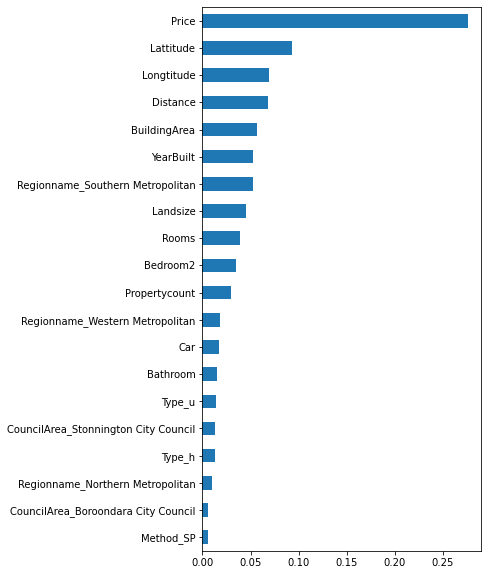

In [55]:
model = RandomForestClassifier(n_estimators=100 , random_state =1, max_leaf_nodes = 100)
model.fit(X_train, y_train)
prediction_test = model.predict(X_test)

precision = round(precision_score(y_test,prediction_test),2)
recall = round(recall_score(y_test,prediction_test),2)
fscore = round(f1_score(y_test,prediction_test),2)
accuracy = round(accuracy_score(y_test,prediction_test),2)
print(f'Accuracy: {accuracy} \nPrecision: {precision} \nRecall: {recall} \nF score: {fscore}')

imp_features = model.feature_importances_
imp_features = pd.Series(imp_features, index=X_train.columns.values)
imp_features.sort_values()[-20:].plot(kind = 'barh', figsize=(5, 10))

In [70]:
model = XGBClassifier(use_label_encoder=False) # XG Boost
model.fit(X_train, y_train)
prediction_test = model.predict(X_test)

precision = round(precision_score(y_test,prediction_test),2)
recall = round(recall_score(y_test,prediction_test),2)
fscore = round(f1_score(y_test,prediction_test),2)
accuracy = round(accuracy_score(y_test,prediction_test),2)
print(f'Accuracy: {accuracy} \nPrecision: {precision} \nRecall: {recall} \nF score: {fscore}')

[19:04:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.99 
Precision: 0.99 
Recall: 0.99 
F score: 0.99


In [386]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

ann_model = Sequential()
ann_model.add(Dense(61, activation='relu',input_dim = 61))
ann_model.add(Dropout(0.2))

ann_model.add(Dense(30, activation='relu'))
ann_model.add(Dropout(0.2))

ann_model.add(Dense(15, activation='relu'))
ann_model.add(Dropout(0.2))

ann_model.add(Dense(7, activation='relu'))
ann_model.add(Dropout(0.2))

ann_model.add(Dense(3, activation='relu'))
ann_model.add(Dropout(0.2))

ann_model.add(Dense(1, activation = 'sigmoid'))

ann_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_history = ann_model.fit(X_train, y_train, validation_split=0.20, batch_size = 1000, epochs = 200, verbose=False)

accuracy = ann_model.evaluate(X_train, y_train, verbose=False)
print("Training Score: {:.2f}".format(accuracy[0]))
print("Training Accuracy: {:.2f}".format(accuracy[1]))

accuracy = ann_model.evaluate(X_test, y_test, verbose=False)
print("Testing Score: {:.2f}".format(accuracy[0]))
print("Testing Accuracy: {:.2f}".format(accuracy[1]))

Training Score: 0.06
Training Accuracy: 0.99
Testing Score: 0.30
Testing Accuracy: 0.94
